In [1]:
# Instalacja wymaganych bibliotek
%pip install scikit-learn shap nltk

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap


# Funkcja do kategoryzacji sentymentu
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df=pd.read_csv('tweets_sentiment.csv')
# Dodanie kolumny z kategoriami sentymentu
df['sentiment'] = df['compound'].apply(categorize_sentiment)




Note: you may need to restart the kernel to use updated packages.


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Przygotowanie danych do modelu
X = df[[ 'negative', 'neutral', 'positive', 'compound']]
y = df['sentiment']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trening modelu Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = model.predict(X_test)

# Raport klasyfikacji
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2104
     neutral       1.00      1.00      1.00      1567
    positive       1.00      1.00      1.00      5000

    accuracy                           1.00      8671
   macro avg       1.00      1.00      1.00      8671
weighted avg       1.00      1.00      1.00      8671



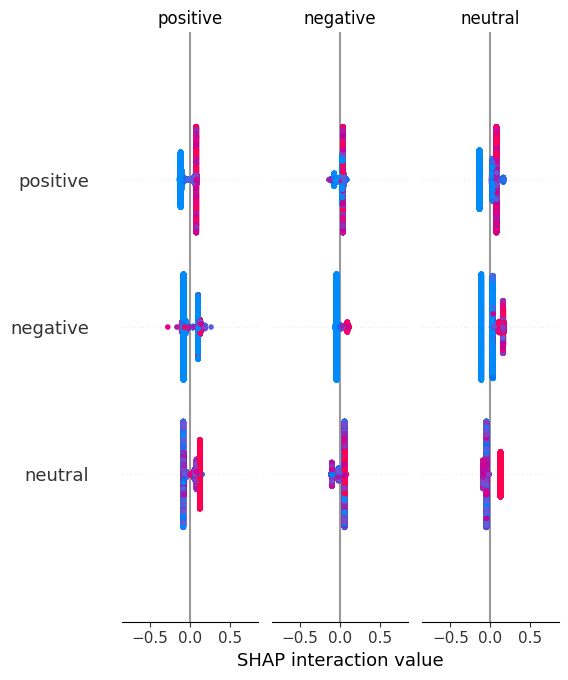

   number  number  number.1  \
0       1       1         1   
1       2       2         2   
2       3       3         3   
3       4       4         4   
4       5       5         5   

                                             content  compound  negative  \
0  sure tune watch donald trump late night david ...    0.4767       0.0   
1  donald trump appearing view tomorrow morning d...    0.7506       0.0   
2  donald trump reads top ten financial tips late...    0.5719       0.0   
3  new blog post celebrity apprentice finale less...    0.0000       0.0   
4  persona never wallflower rather build walls cl...    0.0000       0.0   

   neutral  positive  
0    0.745     0.255  
1    0.652     0.348  
2    0.680     0.320  
3    1.000     0.000  
4    1.000     0.000  


In [3]:
# Analiza SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji
shap.summary_plot(shap_values, X_test)

# Zapisanie wyników do nowego pliku CSV
df['number'] = [i+1 for i, _ in enumerate(df.iterrows())]
df = df[['number'] + list(df.columns[:-1])]
df.to_csv('tweets_sentiment_with_model.csv', index=False)
print(df.head())